In [1]:
source('~/canonades/RcisTarget/src/RCTpipe.r', echo = T, verbose = T)

'envir' chosen:<environment: R_GlobalEnv>
encoding = "native.enc" chosen
 --> from_file='TRUE'
 lines:function (x, ...)  
--> parsed 32 expressions; now eval(.)ing them:

>>>> eval(expression_nr. 1 )

> Sys.setenv(LOG_LEVEL = "TRACE")
curr.fun: symbol Sys.setenv
 .. after ‘expression(Sys.setenv(LOG_LEVEL = "TRACE"))’

>>>> eval(expression_nr. 2 )

> Sys.getenv("R_HOME")
curr.fun: symbol Sys.getenv
[1] "/users/genomics/xoel/canonades/RcisTarget/conda_env/lib/R"
 .. after ‘expression(Sys.getenv("R_HOME"))’

>>>> eval(expression_nr. 3 )

> PAR_METHOD <- "iCisTarget"
curr.fun: symbol <-
 .. after ‘expression(PAR_METHOD <- "iCisTarget")’

>>>> eval(expression_nr. 4 )

> PAR_SEARCH_RANGE <- "long"
curr.fun: symbol <-
 .. after ‘expression(PAR_SEARCH_RANGE <- "long")’

>>>> eval(expression_nr. 5 )

> PAR_MOTIF_NES <- 3
curr.fun: symbol <-
 .. after ‘expression(PAR_MOTIF_NES <- 3)’

>>>> eval(expression_nr. 6 )

> PAR_MOTIF_DB_V <- "V10"
curr.fun: symbol <-
 .. after ‘expression(PAR_MOTIF_DB_V

In [2]:
setwd('~/codebases/cortical_disorders2/results/RCT_diseases/')

In [3]:
load('../../data/graphical.rda', verbose=T)

Loading objects:
  GeneAnnotation
  meta.colors
  facets


In [4]:
load('plots/DiseaseCoreOrders.rda', verbose=T)

Loading objects:
  core.order
  core.levels
  dis.order
  dis.levels


In [5]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# new: `all`

In [6]:
dis.rct <- readRDS('cisTarget_results.rds')
temp.rct <- readRDS('../RCT_peaks/cisTarget_results.rds')

In [120]:
rbind(
    dis.rct$motifEnrichmentTableLongSelf%>%mutate(dataset='Disease'),
    temp.rct$motifEnrichmentTableLongSelf%>%mutate(dataset='Temporal')
    ) %>% rename(Core=TF_highConf, Target=enrichedGenes) %>% select(Core,Target, dataset, geneSet) %>%
arrange(Core, Target) %>% unique() -> edges
edges$Regulon <- paste(edges$geneSet, edges$Core)

In [132]:
edges.list <- list(
    edges %>% reshape2::dcast('Core + Target ~ dataset', fun.aggregate = length),
    edges %>% reshape2::dcast('Core + Target ~ dataset+geneSet', fun.aggregate = length),
    edges %>% reshape2::dcast('Core + Target ~ Regulon', fun.aggregate = length)
)
edges.2 <- edges.list[[1]]
for (i in 2:length(edges.list)){
    edges.2 <- merge(edges.2, edges.list[[i]], by=c('Core', 'Target'), all=T)
}


edges %>% group_by(Core, Target) %>% summarise_all(function(x){paste(sort(unique(c(unlist(strsplit(x, split=',')), recursive=T))), collapse=',')}) -> edges.sum
edges.2 <- merge(edges.2, edges.sum, by=c('Core', 'Target'), all=T)

Using Regulon as value column: use value.var to override.

Using Regulon as value column: use value.var to override.

Using Regulon as value column: use value.var to override.



In [133]:
nodes <- list(
rbind(
    reshape2::dcast(edges, 'Core~dataset', value.var='Target', 
                    fun.aggregate=function(x){ifelse(length(x)>0, 'Core', '')}) %>%rename(Gene=Core),
    reshape2::dcast(edges, 'Target~dataset', value.var='Core', 
                    fun.aggregate=function(x){ifelse(length(x)>0, 'Target', '')}) %>%rename(Gene=Target)),
rbind(
    reshape2::dcast(edges, 'Core~dataset+geneSet', value.var='Target', 
                    fun.aggregate=function(x){ifelse(length(x)>0, 'Core', '')}) %>%rename(Gene=Core),
    reshape2::dcast(edges, 'Target~dataset+geneSet', value.var='Core', 
                    fun.aggregate=function(x){ifelse(length(x)>0, 'Target', '')}) %>%rename(Gene=Target)),
rbind(
    reshape2::dcast(edges, 'Core~dataset+Regulon', value.var='Target', 
                    fun.aggregate=function(x){ifelse(length(x)>0, 'Core', '')}) %>%rename(Gene=Core),
    reshape2::dcast(edges, 'Target~dataset+Regulon', value.var='Core', 
                    fun.aggregate=function(x){ifelse(length(x)>0, 'Target', '')}) %>%rename(Gene=Target))
)
nodes.2 <- nodes[[1]]
for (i in 2:length(nodes)){
    nodes.2 <- merge(nodes.2, nodes[[i]], by='Gene', all=T)
}
nodes.2 %>% group_by(Gene) %>% summarise_all(function(x){paste(sort(unique(c(unlist(strsplit(x, split=',')), recursive=T))), collapse=',')}) -> nodes.2

In [134]:
col2hex <- function(x, alpha=NULL){
    co <- col2rgb(x)
    return(rgb(co[1], co[2], co[3], maxColorValue = 255, alpha=alpha))
}

In [135]:
sub.annotation <- GeneAnnotation[,c('GeneHuman','PeakSample','PeakSampleColor','PeakSampleFct')]

In [136]:
# nodes%>% select(Gene)%>%unique()->nodes.2
# nodes->nodes.2
nodes.2 <- merge(nodes.2, sub.annotation, by.x='Gene', by.y='GeneHuman', all.x=T, all.y=F)
nodes.2 %>%
    mutate_if(as.numeric, .predicate = is.factor)  %>%
    mutate_if(function(x){ifelse(is.na(x), '#FFFFFF',ifelse(grepl(pattern = '^#', x=x), x, col2hex(x)))}, .predicate = function(x){any(grepl(pattern = '^#', x=x))}) -> nodes.2

paste(ifelse(nodes.2$Gene %in% dis.rct$regulonTbl$Core, 'Dis', ''),
      ifelse(nodes.2$Gene %in% temp.rct$regulonTbl$Core, 'Tem', '')) -> nodes.2$IsCore
nodes.2%>%arrange(desc(IsCore), PeakSampleFct) -> nodes.2


In [137]:
cbind(dis.rct$input.df, data.frame(AnyRisk=rowSums(dis.rct$input.df[,-1]))) %>%
    apply(2, function(x){ifelse(as.logical(x), 'Risk', 'No')}) %>% as.data.frame -> risk.info

risk.info$Gene <- rownames(dis.rct$input.df)

nodes.2 <- merge(x = nodes.2, by='Gene', all.x=T,
      y=risk.info, all.y=F) %>% mutate_all(function(x){ifelse(is.na(x), 'No', x)})

In [138]:
sum(duplicated(nodes.2$Gene))

[1] 0

## Export networks

In [139]:
network <- igraph::graph_from_data_frame(d=edges.2, directed = TRUE, vertices = nodes.2)

In [140]:
igraph::write_graph(
  network,
  file='../all_networks.gml',
  format = "gml")

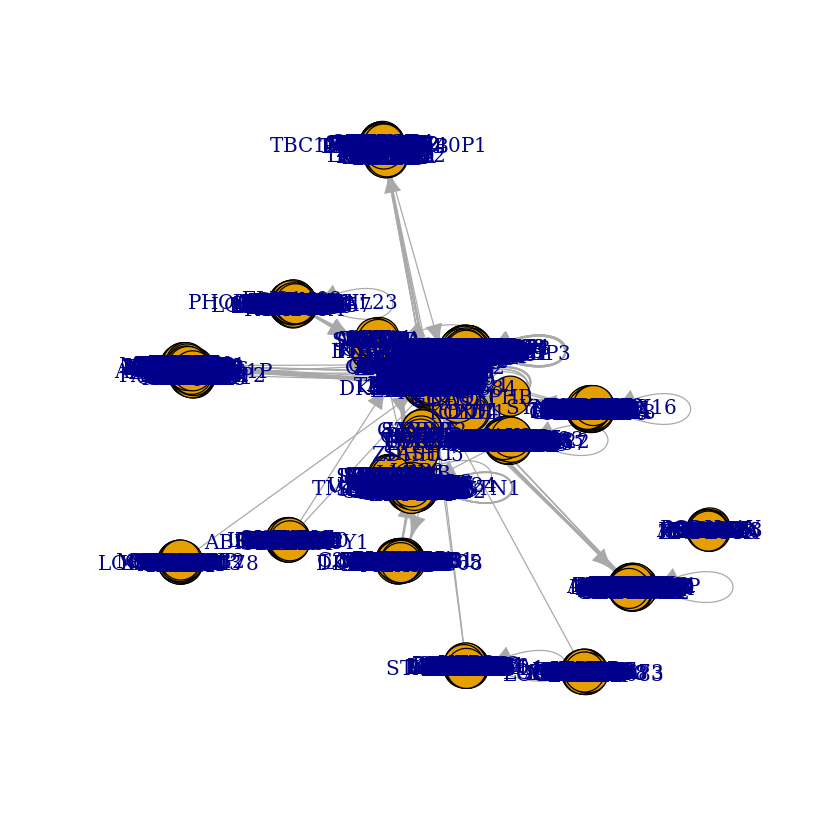

In [130]:
plot(network)

# Network: nodes and edges

In [6]:
# perm.RCT <- readRDS('cisTarget_results.permuted.rds')
RCT <- readRDS('cisTarget_results.rds')

In [7]:
RCT$summaryTbl[,-c(4,6)] %>% group_by(TF_highConf) %>% summarise_all(.funs = function(x) paste(unique(x),collapse = ','))

TF_highConf,geneSet,n.motifs,n.targets
<chr>,<chr>,<chr>,<chr>
ARNT2,ASD,1,202
CHD1,ASD,1,420
CNOT3,DD,1,33
CTCF,DD,1,36
DLX2,FCDandmTOR,1,7
EGR3,ASD,2,455
EP300,"ASD,DD,NEUROT_2018",1,"339,47,80"
FOXG1,Lissencephaly,1,5
FOXO3,SCZ_2020,1,48


## nodes

In [8]:
nodeTbl <- data.frame(Gene=sort(unique(unlist(RCT$regulonTbl[,c('Core', 'Target')]))))

# head(nodeTbl)

nodeTbl <- merge(
    nodeTbl, GeneAnnotation,
    by.x='Gene', by.y='GeneHuman',
    all.x=T, all.y=F)[,c('Gene', 'PeakSample', 'PeakSampleFct', 'PeakSampleColor')]

head(nodeTbl)

,Gene,PeakSample,PeakSampleFct,PeakSampleColor
,<chr>,<chr>,<fct>,<chr>
1,ABAT,P4.FGF10,P4.FGF10,#DE2D26
2,ABCA7,P3.FGF1,P3.FGF1,#6BAED6
3,ACHE,P8.FGF1,P8.FGF1,#969696
4,ACTN4,P8.FGF0.1,P8.FGF0.1,#CCCCCC
5,ADCY3,P8.FGF0.1,P8.FGF0.1,#CCCCCC
6,ADCY5,P8.FGF0.1,P8.FGF0.1,#CCCCCC


In [9]:
regulon.targets <- reshape2::dcast(data.frame(
    Regulon=apply(RCT$regulonTbl[,c('geneSet', 'Core')], 1, function(x){
        paste0(paste(x, collapse='__'), '.target')}),
    Gene=RCT$regulonTbl$Target),
                'Gene ~ Regulon', fun.aggregate=function(x)length(unique(x)))

regulon.targets$Any_regulon.target <- as.numeric(rowSums(regulon.targets[,-1]) > 0)


regulon.targets$regulon.targets.which <- apply(
    regulon.targets[,-c(1, ncol(regulon.targets))],
    1,
    function(x){
        paste(names(x)[x==1], collapse=', ')
    })
nodeTbl <- merge(
    nodeTbl, regulon.targets,
    by.x='Gene', by.y='Gene',
    all.x=T, all.y=F)
nodeTbl[, colnames(regulon.targets[,-1])][is.na(nodeTbl[, colnames(regulon.targets[,-1])])] <- 0
# head(nodeTbl)
            

geneset.targets <- reshape2::dcast(data.frame(
    geneSet=paste0(RCT$regulonTbl$geneSet, '.target'),
    Gene=RCT$regulonTbl$Target),
                'Gene ~ geneSet', fun.aggregate=function(x)length(unique(x)))

geneset.targets$Any_geneset.target <- as.numeric(rowSums(geneset.targets[,-1]) > 0)

geneset.targets$geneset.targets.which <- apply(
    geneset.targets[,-c(1, ncol(geneset.targets))],
    1,
    function(x){
        paste(names(x)[x==1], collapse=', ')
    })


nodeTbl <- merge(
    nodeTbl, geneset.targets,
    by.x='Gene', by.y='Gene',
    all.x=T, all.y=F)
nodeTbl[, colnames(geneset.targets[,-1])][is.na(nodeTbl[, colnames(geneset.targets[,-1])])] <- 0
# head(nodeTbl)

regulon.cores <- reshape2::dcast(data.frame(
    Regulon=apply(RCT$regulonTbl[,c('geneSet', 'Core')], 1, function(x){
        paste0(paste(x, collapse='__'), '.core')}),
    Gene=RCT$regulonTbl$Core),
                'Gene ~ Regulon', fun.aggregate=function(x)length(unique(x)))

regulon.cores$Any_regulon.core <- as.numeric(rowSums(regulon.cores[,-1]) > 0)

regulon.cores$regulon.cores.which <- apply(
    regulon.cores[,-c(1, ncol(regulon.cores))],
    1,
    function(x){
        paste(names(x)[x==1], collapse=', ')
    })

nodeTbl <- merge(
    nodeTbl, regulon.cores,
    by.x='Gene', by.y='Gene',
    all.x=T, all.y=F)
nodeTbl[, colnames(regulon.cores[,-1])][is.na(nodeTbl[, colnames(regulon.cores[,-1])])] <- 0
# head(nodeTbl)
            

geneset.cores <- reshape2::dcast(data.frame(
    geneSet=paste0(RCT$regulonTbl$geneSet, '.core'),
    Gene=RCT$regulonTbl$Core),
                'Gene ~ geneSet', fun.aggregate=function(x)length(unique(x)))

geneset.cores$Any_geneset.core <- as.numeric(rowSums(geneset.cores[,-1]) > 0)

geneset.cores$geneset.cores.which <- apply(
    geneset.cores[,-c(1, ncol(geneset.cores))],
    1,
    function(x){
        paste(names(x)[x==1], collapse=', ')
    })
                                 
nodeTbl <- merge(
    nodeTbl, geneset.cores,
    by.x='Gene', by.y='Gene',
    all.x=T, all.y=F)
nodeTbl[, colnames(geneset.cores[,-1])][is.na(nodeTbl[, colnames(geneset.cores[,-1])])] <- 0
# head(nodeTbl)
            

regulon.genes <- RCT$regulonTbl %>%
    group_by(geneSet, Core) %>% summarise(
        Gene = union(Core, Target))

regulon.genes <- reshape2::dcast(data.frame(
    Regulon=apply(regulon.genes[,c('geneSet', 'Core')], 1, function(x){
        paste0(paste(x, collapse='__'), '.gene')}),
    Gene=regulon.genes$Gene),
                'Gene ~ Regulon', fun.aggregate=function(x)length(unique(x)))

regulon.genes$Any_regulon.gene <- as.numeric(rowSums(regulon.genes[,-1]) > 0)  

regulon.genes$regulon.genes.which <- apply(
    regulon.genes[,-c(1, ncol(regulon.genes))],
    1,
    function(x){
        paste(names(x)[x==1], collapse=', ')
    })
                                 
nodeTbl <- merge(
    nodeTbl, regulon.genes,
    by.x='Gene', by.y='Gene',
    all.x=T, all.y=F)
nodeTbl[, colnames(regulon.genes[,-1])][is.na(nodeTbl[, colnames(regulon.genes[,-1])])] <- 0
# head(nodeTbl)
                        
### WORKING            
geneset_regulon.genes <- RCT$regulonTbl %>%
    group_by(geneSet) %>% summarise(
        Gene = union(Core, Target))

geneset_regulon.genes <- reshape2::dcast(data.frame(
    geneSet=paste0(geneset_regulon.genes$geneSet, '_regulon.gene'),
    Gene=geneset_regulon.genes$Gene),
                'Gene ~ geneSet', fun.aggregate=function(x)length(unique(x)))

geneset_regulon.genes$Any_geneset_regulon.gene <- as.numeric(rowSums(geneset_regulon.genes[,-1]) > 0)  

geneset_regulon.genes$geneset_regulon.genes.which <- apply(
    geneset_regulon.genes[,-c(1, ncol(geneset_regulon.genes))],
    1,
    function(x){
        paste(names(x)[x==1], collapse=', ')
    })
                                 
nodeTbl <- merge(
    nodeTbl, geneset_regulon.genes,
    by.x='Gene', by.y='Gene',
    all.x=T, all.y=F)
nodeTbl[, colnames(geneset_regulon.genes[,-1])][is.na(nodeTbl[, colnames(geneset_regulon.genes[,-1])])] <- 0
# head(nodeTbl)
                        
            

geneset.genes <-  RCT$clean.df
colnames(geneset.genes) <- paste0(colnames(geneset.genes), '.gene')
geneset.genes$Any_geneset.genes <- as.numeric(rowSums(geneset.genes) > 0)  
geneset.genes$Gene <- rownames(geneset.genes)


geneset.genes$geneset.genes.which <- apply(
    geneset.genes[,rev(colnames(geneset.genes))[-c(1:2)]],
    1,
    function(x){
        paste(names(x)[x==1], collapse=', ')
    })


                                 
nodeTbl <- merge(
    nodeTbl, geneset.genes,
    by.x='Gene', by.y='Gene',
    all.x=T, all.y=F)
nodeTbl[, colnames(geneset.genes[,-ncol(geneset.genes)])][is.na(nodeTbl[, colnames(geneset.genes[,-ncol(geneset.genes)])])] <- 0
# head(nodeTbl)
            

Using Gene as value column: use value.var to override.

Using Gene as value column: use value.var to override.

Using Gene as value column: use value.var to override.

Using Gene as value column: use value.var to override.

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'geneSet', 'Core'. You can override using
the `.groups` argument.
Using Gene as value column: use value.var to override.

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'geneSet

In [10]:
nodeTbl[,grep('which',colnames(nodeTbl))][nodeTbl[,grep('which',colnames(nodeTbl))] == 0] <- 'None'

In [11]:
nodeTbl$PeakSampleOrder <- as.numeric(nodeTbl$PeakSampleFct)

In [13]:
regulon_genesets_whichs <- sort(unique(subset(nodeTbl, Any_geneset.core==1)$geneset_regulon.genes.which))
regulon_genesets_whichs.unique <- sort(unique(unlist(strsplit(split = ', ', subset(nodeTbl, Any_geneset.core==1)$geneset_regulon.genes.which))))
regulon_genesets_whichs.notunique <- regulon_genesets_whichs[!regulon_genesets_whichs%in%regulon_genesets_whichs.unique]



In [14]:
regulon_genesets_whichs
regulon_genesets_whichs.unique
regulon_genesets_whichs.notunique

[1] "ASD_regulon.gene"                                                                  
 [2] "ASD_regulon.gene, DD_regulon.gene"                                                 
 [3] "ASD_regulon.gene, DD_regulon.gene, MDD_2018_regulon.gene, NEUROT_2018_regulon.gene"
 [4] "ASD_regulon.gene, DD_regulon.gene, NEUROT_2018_regulon.gene"                       
 [5] "ASD_regulon.gene, Lissencephaly_regulon.gene"                                      
 [6] "BD_2019_regulon.gene"                                                              
 [7] "DD_regulon.gene"                                                                   
 [8] "FCDandmTOR_regulon.gene"                                                           
 [9] "Hydrocephaly_regulon.gene"                                                         
[10] "NEUROT_2018_regulon.gene"                                                          
[11] "SCZ_2020_regulon.gene"

[1] "ASD_regulon.gene"           "BD_2019_regulon.gene"      
[3] "DD_regulon.gene"            "FCDandmTOR_regulon.gene"   
[5] "Hydrocephaly_regulon.gene"  "Lissencephaly_regulon.gene"
[7] "MDD_2018_regulon.gene"      "NEUROT_2018_regulon.gene"  
[9] "SCZ_2020_regulon.gene"

[1] "ASD_regulon.gene, DD_regulon.gene"                                                 
[2] "ASD_regulon.gene, DD_regulon.gene, MDD_2018_regulon.gene, NEUROT_2018_regulon.gene"
[3] "ASD_regulon.gene, DD_regulon.gene, NEUROT_2018_regulon.gene"                       
[4] "ASD_regulon.gene, Lissencephaly_regulon.gene"

In [18]:
regulon_genesets_whichs.pal <- ggsci::pal_d3(
  palette = "category20",
  alpha = 1)(10)
regulon_genesets_whichs.pal <- sapply(regulon_genesets_whichs.pal, substr, start = 1, stop = 7)
regulon_genesets_whichs.colors <- c(
    setNames(regulon_genesets_whichs.pal[c(9, 3, 4, 5, 7, 10, 1, 2, 6)], regulon_genesets_whichs.unique),
    setNames(rep(regulon_genesets_whichs.pal[8], length(regulon_genesets_whichs.notunique)), regulon_genesets_whichs.notunique))

In [27]:
regulon_genesets_whichs <- sort(unique(subset(nodeTbl, Any_geneset.core==1)$geneset_regulon.genes.which))
regulon_genesets_whichs.unique <- sort(unique(unlist(strsplit(split = ', ', subset(nodeTbl, Any_geneset.core==1)$geneset_regulon.genes.which))))
regulon_genesets_whichs.notunique <- regulon_genesets_whichs[!regulon_genesets_whichs%in%regulon_genesets_whichs.unique]

regulon_genesets_whichs.pal <- ggsci::pal_d3(
  palette = "category20",
  alpha = 1)(10)
regulon_genesets_whichs.pal <- sapply(regulon_genesets_whichs.pal, substr, start = 1, stop = 7)

regulon_genesets_whichs.colors <- c(
    setNames(meta.colors[['Disease']][gsub('_regulon.gene', '', regulon_genesets_whichs.unique, fixed=T)],
             regulon_genesets_whichs.unique),
    setNames(rep('#ffffff', length(regulon_genesets_whichs.notunique)), 
             regulon_genesets_whichs.notunique))

In [28]:
regulon_genesets_whichs.colors

ASD_regulon.gene 
                                                                         "#bcbd22" 
                                                              BD_2019_regulon.gene 
                                                                         "#cca38c" 
                                                                   DD_regulon.gene 
                                                                         "#00977b" 
                                                           FCDandmTOR_regulon.gene 
                                                                         "#d844ab" 
                                                         Hydrocephaly_regulon.gene 
                                                                         "#1a5354" 
                                                        Lissencephaly_regulon.gene 
                                                                         "#17becf" 
                                                             MDD_2018_regulon.gene 
                                                                         "#f399c0" 
                                                          NEUROT_2018_regulon.gene 
                                                                         "#ff7f0e" 
                                                             SCZ_2020_regulon.gene 
                                                                         "#8c564b" 
                                                 ASD_regulon.gene, DD_regulon.gene 
                                                                         "#ffffff" 
ASD_regulon.gene, DD_regulon.gene, MDD_2018_regulon.gene, NEUROT_2018_regulon.gene 
                                                                         "#ffffff" 
                       ASD_regulon.gene, DD_regulon.gene, NEUROT_2018_regulon.gene 
                                                                         "#ffffff" 
                                      ASD_regulon.gene, Lissencephaly_regulon.gene 
                                                                         "#ffffff"

In [29]:
#C49C94
#DBDB8D
#F7B6D2

                                                                  ASD_regulon.gene 
                                                                         "#bcbd22" 
                                                              BD_2019_regulon.gene 
                                                                         "#cca38c" 
                                                                   DD_regulon.gene 
                                                                         "#00977b" 
                                                           FCDandmTOR_regulon.gene 
                                                                         "#d844ab" 
                                                         Hydrocephaly_regulon.gene 
                                                                         "#1a5354" 
                                                        Lissencephaly_regulon.gene 
                                                                         "#1

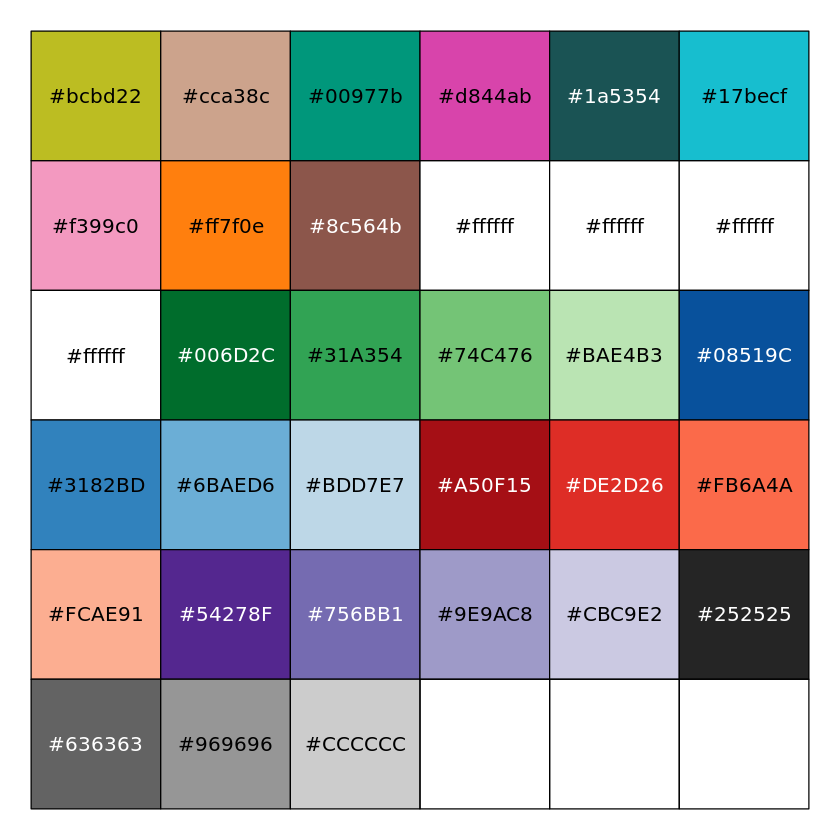

In [30]:
print(regulon_genesets_whichs.colors)
scales::show_col(c(regulon_genesets_whichs.colors, meta.colors$PeakSample))

In [31]:
library(ggplot2)
library(ggpubr)

In [32]:
dis.leg <- cowplot::get_legend(ggplot(data=data.frame(colors=regulon_genesets_whichs.colors, 
                       disease=names(regulon_genesets_whichs.colors))) +
    geom_point(aes(x=disease,y=1, color=disease), shape=16, size=5) + 
    scale_color_manual('Disease', values=regulon_genesets_whichs.colors) + labs_pubr() + theme_pubr(base_family = 'ArialMT', legend = 'right'))

In [33]:
pdf(file = 'plots/disease_legend.pdf')
plot(dis.leg)
dev.off()

png 
  2

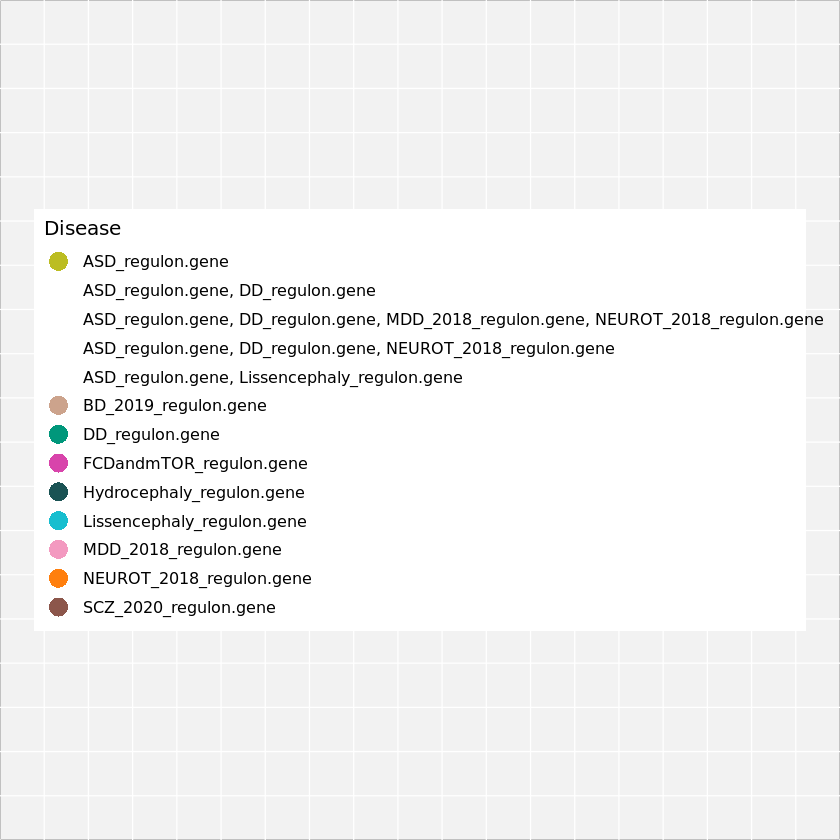

In [34]:
plot(dis.leg)

In [35]:
regulon_genesets_whichs.labels <- setNames(
    rep('#000000',times = length(regulon_genesets_whichs.colors)),
    names(regulon_genesets_whichs.colors))

regulon_genesets_whichs.labels[regulon_genesets_whichs.colors%in%c('#1F77B4','#8C564B', '#D62728')] <- '#FFFFFF'

In [36]:
regulon_genesets_whichs.colors

ASD_regulon.gene 
                                                                         "#bcbd22" 
                                                              BD_2019_regulon.gene 
                                                                         "#cca38c" 
                                                                   DD_regulon.gene 
                                                                         "#00977b" 
                                                           FCDandmTOR_regulon.gene 
                                                                         "#d844ab" 
                                                         Hydrocephaly_regulon.gene 
                                                                         "#1a5354" 
                                                        Lissencephaly_regulon.gene 
                                                                         "#17becf" 
                                                             MDD_2018_regulon.gene 
                                                                         "#f399c0" 
                                                          NEUROT_2018_regulon.gene 
                                                                         "#ff7f0e" 
                                                             SCZ_2020_regulon.gene 
                                                                         "#8c564b" 
                                                 ASD_regulon.gene, DD_regulon.gene 
                                                                         "#ffffff" 
ASD_regulon.gene, DD_regulon.gene, MDD_2018_regulon.gene, NEUROT_2018_regulon.gene 
                                                                         "#ffffff" 
                       ASD_regulon.gene, DD_regulon.gene, NEUROT_2018_regulon.gene 
                                                                         "#ffffff" 
                                      ASD_regulon.gene, Lissencephaly_regulon.gene 
                                                                         "#ffffff"

In [37]:
nodeTbl$diseaseColor <- regulon_genesets_whichs.colors[
    nodeTbl$geneset_regulon.genes.which
]

nodeTbl$diseaseColorLabel <- regulon_genesets_whichs.labels[
    nodeTbl$geneset_regulon.genes.which
]

In [38]:
rownames(nodeTbl) <- nodeTbl$Gene

In [39]:
apply(nodeTbl, 2, function(x)head(unique(x)))
head(nodeTbl)

$Gene
[1] "ABAT"  "ABCA7" "ACHE"  "ACTN4" "ADCY3" "ADCY5"

$PeakSample
[1] "P4.FGF10"  "P3.FGF1"   "P8.FGF1"   "P8.FGF0.1" "P2.FGF20"  "P4.FGF0.1"

$PeakSampleFct
[1] "P4.FGF10"  "P3.FGF1"   "P8.FGF1"   "P8.FGF0.1" "P2.FGF20"  "P4.FGF0.1"

$PeakSampleColor
[1] "#DE2D26" "#6BAED6" "#969696" "#CCCCCC" "#006D2C" "#FCAE91"

$ASD__ARNT2.target
[1] "0" "1"

$ASD__CHD1.target
[1] "1" "0"

$ASD__EGR3.target
[1] "1" "0"

$ASD__EP300.target
[1] "1" "0"

$ASD__GLIS1.target
[1] "0" "1"

$ASD__GTF2I.target
[1] "1" "0"

$ASD__KLF16.target
[1] "1" "0"

$ASD__MTF1.target
[1] "1" "0"

$ASD__PAX5.target
[1] "1" "0"

$ASD__SIN3A.target
[1] "1" "0"

$ASD__TAF1.target
[1] "1" "0"

$ASD__THRA.target
[1] "1" "0"

$ASD__VDR.target
[1] "1" "0"

$ASD__VEZF1.target
[1] "1" "0"

$ASD__YY1.target
[1] "0" "1"

$BD_2019__ZNF101.target
[1] "0" "1"

$DD__CNOT3.target
[1] "0" "1"

$DD__CTCF.target
[1] "0" "1"

$DD__EP300.target
[1] "0" "1"

$DD__PURA.target
[1] "0" "1"

$FCDandmTOR__DLX2.target
[1] "0" "1"

$FCDandmTOR__KLF4.target
[1] "0" "1"

$Hydrocephaly__SKI.target
[1] "0" "1"

$Lissencephaly__FOXG1.target
[1] "0" "1"

$MDD_2018__MEF2C.target
[1] "0" "1"

$NEUROT_2018__EP300.target
[1] "0" "1"

$NEUROT_2018__GLIS3.target
[1] "0" "1"

$NEUROT_2018__GTF2IRD1.target
[1] "0" "1"

$SCZ_2020__FOXO3.target
[1] "0" "1"

$SCZ_2020__KLF6.target
[1] "0" "1"

$SCZ_2020__SP4.target
[1] "0" "1"

$Any_regulon.target
[1] "1" "0"

$regulon.targets.which
[1] "ASD__CHD1.target, ASD__EGR3.target, ASD__EP300.target, ASD__GTF2I.target, ASD__KLF16.target, ASD__MTF1.target, ASD__PAX5.target, ASD__SIN3A.target, ASD__TAF1.target, ASD__THRA.target, ASD__VDR.target, ASD__VEZF1.target"
[2] "ASD__GLIS1.target"                                                                                                                                                                                                         
[3] "ASD__EGR3.target, ASD__KLF16.target"                                                                                                                                                                                       
[4] "ASD__VEZF1.target"                                                                                                                                                                                                         
[5] "ASD__CHD1.target, ASD__EGR3.target, ASD__KLF16.target"                                                                                                                                                                     
[6] "ASD__CHD1.target, ASD__KLF16.target, ASD__PAX5.target, ASD__VEZF1.target"                                                                                                                                                  

$ASD.target
[1] "1" "0"

$BD_2019.target
[1] "0" "1"

$DD.target
[1] "0" "1"

$FCDandmTOR.target
[1] "0" "1"

$Hydrocephaly.target
[1] "0" "1"

$Lissencephaly.target
[1] "0" "1"

$MDD_2018.target
[1] "0" "1"

$NEUROT_2018.target
[1] "0" "1"

$SCZ_2020.target
[1] "0" "1"

$Any_geneset.target
[1] "1" "0"

$geneset.targets.which
[1] "ASD.target"                         "ASD.target, DD.target"             
[3] "NEUROT_2018.target"                 "FCDandmTOR.target"                 
[5] "FCDandmTOR.target, SCZ_2020.target" "DD.target"                         

$ASD__ARNT2.core
[1] "0" "1"

$ASD__CHD1.core
[1] "0" "1"

$ASD__EGR3.core
[1] "0" "1"

$ASD__EP300.core
[1] "0" "1"

$ASD__GLIS1.core
[1] "0" "1"

$ASD__GTF2I.core
[1] "0" "1"

$ASD__KLF16.core
[1] "0" "1"

$ASD__MTF1.core
[1] "0" "1"

$ASD__PAX5.core
[1] "0" "1"

$ASD__SIN3A.core
[1] "0" "1"

$ASD__TAF1.core
[1] "0" "1"

$ASD__THRA.core
[1] "0" "1"

$ASD__VDR.core
[1] "0" "1"

$ASD__VEZF1.core
[1] "0" "1"

$ASD__YY1.core
[1] "0" "1"

$BD_2019__ZNF101.core
[1] "0" "1"

$DD__CNOT3.core
[1] "0" "1"

$DD__CTCF.core
[1] "0" "1"

$DD__EP300.core
[1] "0" "1"

$DD__PURA.core
[1] "0" "1"

$FCDandmTOR__DLX2.core
[1] "0" "1"

$FCDandmTOR__KLF4.core
[1] "0

,Gene,PeakSample,PeakSampleFct,PeakSampleColor,ASD__ARNT2.target,ASD__CHD1.target,ASD__EGR3.target,ASD__EP300.target,ASD__GLIS1.target,ASD__GTF2I.target,⋯,ADHD_2019.gene,DD.gene,FCDandmTOR.gene,Cobblestone.gene,ASD.gene,Any_geneset.genes,geneset.genes.which,PeakSampleOrder,diseaseColor,diseaseColorLabel
,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>,<chr>
ABAT,ABAT,P4.FGF10,P4.FGF10,#DE2D26,0,1,1,1,0,1,⋯,0,0,0,0,1,1,ASD.gene,10,#bcbd22,#000000
ABCA7,ABCA7,P3.FGF1,P3.FGF1,#6BAED6,0,0,0,0,1,0,⋯,0,0,0,0,1,1,"ASD.gene, AD_2019.gene",7,#bcbd22,#000000
ACHE,ACHE,P8.FGF1,P8.FGF1,#969696,0,0,1,0,0,0,⋯,0,0,0,0,1,1,ASD.gene,19,#bcbd22,#000000
ACTN4,ACTN4,P8.FGF0.1,P8.FGF0.1,#CCCCCC,0,0,0,0,0,0,⋯,0,0,0,0,1,1,ASD.gene,20,#bcbd22,#000000
ADCY3,ADCY3,P8.FGF0.1,P8.FGF0.1,#CCCCCC,0,1,1,0,0,0,⋯,0,0,0,0,1,1,ASD.gene,20,#bcbd22,#000000
ADCY5,ADCY5,P8.FGF0.1,P8.FGF0.1,#CCCCCC,0,1,0,0,0,0,⋯,0,0,0,0,1,1,ASD.gene,20,#bcbd22,#000000


In [40]:
colnames(nodeTbl)[apply(nodeTbl,
      2, function(x) any(is.na(x))
     )]

[1] "diseaseColor"      "diseaseColorLabel"

In [63]:
discol.testdf <- unique(subset(nodeTbl, as.logical(Any_regulon.core))[,c('Gene', 'regulon.cores.which', 'geneset_regulon.genes.which', 'diseaseColor', 'diseaseColorLabel')])
discol.testdf

,Gene,regulon.cores.which,geneset_regulon.genes.which,diseaseColor,diseaseColorLabel
,<chr>,<chr>,<chr>,<chr>,<chr>
ARNT2,ARNT2,ASD__ARNT2.core,ASD_regulon.gene,#bcbd22,#000000
CHD1,CHD1,ASD__CHD1.core,ASD_regulon.gene,#bcbd22,#000000
CNOT3,CNOT3,DD__CNOT3.core,"ASD_regulon.gene, DD_regulon.gene",#ffffff,#000000
CTCF,CTCF,DD__CTCF.core,"ASD_regulon.gene, DD_regulon.gene",#ffffff,#000000
DLX2,DLX2,FCDandmTOR__DLX2.core,FCDandmTOR_regulon.gene,#d844ab,#000000
EGR3,EGR3,ASD__EGR3.core,ASD_regulon.gene,#bcbd22,#000000
EP300,EP300,"ASD__EP300.core, DD__EP300.core, NEUROT_2018__EP300.core","ASD_regulon.gene, DD_regulon.gene, NEUROT_2018_regulon.gene",#ffffff,#000000
FOXG1,FOXG1,Lissencephaly__FOXG1.core,"ASD_regulon.gene, Lissencephaly_regulon.gene",#ffffff,#000000
FOXO3,FOXO3,SCZ_2020__FOXO3.core,SCZ_2020_regulon.gene,#8c564b,#000000


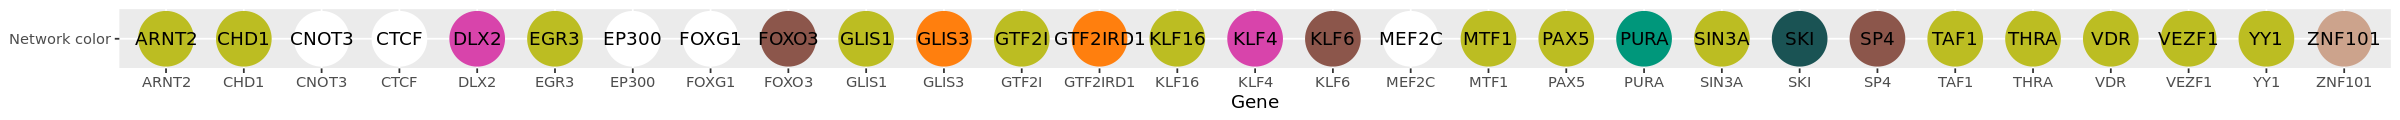

In [78]:
options(repr.plot.height=1, repr.plot.width=20)
ggplot(discol.testdf, 
       aes(x=Gene, label=Gene, 
           color=diseaseColor, y = 'Network color')) + ylab(NULL) +
    scale_color_identity() + 
    geom_point(size=15) + 
    geom_text(color='black')

## edges

In [42]:
edgeTbl <- RCT$regulonTbl %>% group_by(Core, Target) %>% summarise_all(.funs=function(x){paste(unique(x), collapse=',')})

In [43]:
nrow(RCT$regulonTbl) - nrow(edgeTbl)

[1] 55

In [44]:
edgeTbl <- edgeTbl %>% merge(
    y=nodeTbl,
    by.x='Core', by.y='Gene', 
    all.x=T, all.y=F
) %>% merge(
    y=nodeTbl,
    by.x='Target', by.y='Gene', 
    all.x=T, all.y=F,
    suffixes=c('.Core', '.Target')
)

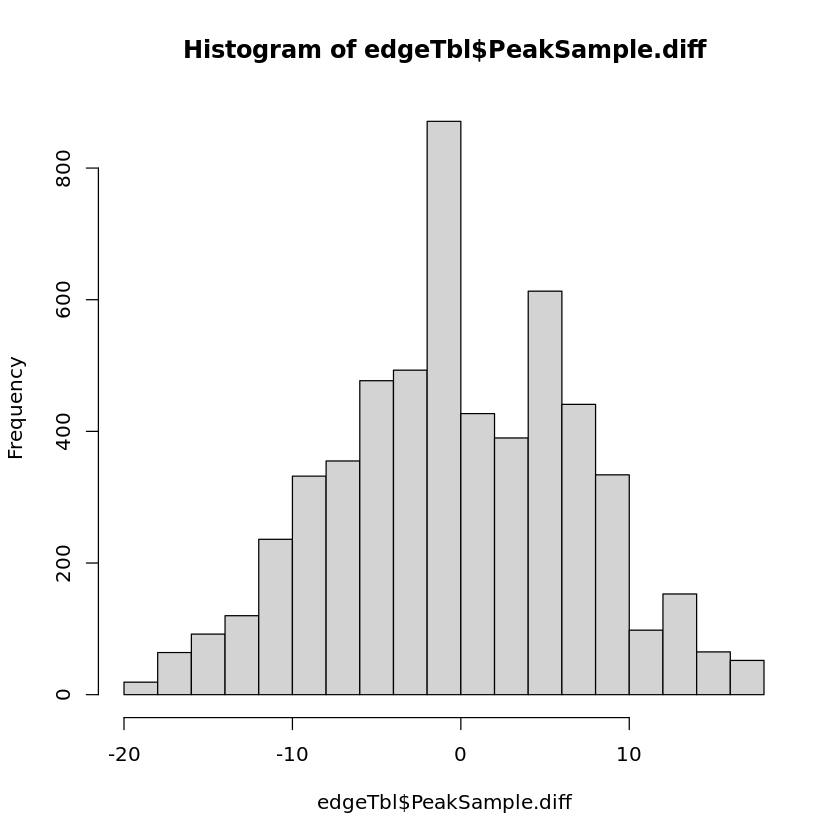

In [45]:
edgeTbl$PeakSample.diff <- edgeTbl$PeakSampleOrder.Target - edgeTbl$PeakSampleOrder.Core
hist(edgeTbl$PeakSample.diff)

In [46]:
edgeTbl$PeakSample.orient <- cut(
    edgeTbl$PeakSample.diff, 
    breaks = c(-Inf, -1, 0, Inf), 
    labels = c('Target peaks earlier',
               'Target peak = Core peak', 
               'Target peaks later'))

In [47]:
edgeTbl <- edgeTbl[,c(2,1,3:ncol(edgeTbl))]

In [48]:
head(edgeTbl[grep(',', edgeTbl$geneSet),])
head(edgeTbl)
head(edgeTbl[,c(1,2, grep('PeakSample', colnames(edgeTbl)))])

,Core,Target,geneSet,n.motifs,all.motifs,PeakSample.Core,PeakSampleFct.Core,PeakSampleColor.Core,ASD__ARNT2.target.Core,ASD__CHD1.target.Core,⋯,FCDandmTOR.gene.Target,Cobblestone.gene.Target,ASD.gene.Target,Any_geneset.genes.Target,geneset.genes.which.Target,PeakSampleOrder.Target,diseaseColor.Target,diseaseColorLabel.Target,PeakSample.diff,PeakSample.orient
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<fct>
40,EP300,ADNP,"ASD,DD",1,tfdimers__MD00537,P4.FGF0.1,P4.FGF0.1,#FCAE91,0,1,⋯,0,0,1,1,"ASD.gene, DD.gene",12,#ffffff,#000000,0,Target peak = Core peak
81,EP300,AHDC1,"ASD,DD",1,tfdimers__MD00537,P4.FGF0.1,P4.FGF0.1,#FCAE91,0,1,⋯,0,0,1,1,"ASD.gene, DD.gene",7,#ffffff,#000000,-5,Target peaks earlier
294,EP300,ASXL3,"ASD,DD",1,tfdimers__MD00537,P4.FGF0.1,P4.FGF0.1,#FCAE91,0,1,⋯,0,0,1,1,"ASD.gene, DD.gene",12,#ffffff,#000000,0,Target peak = Core peak
343,EP300,AUTS2,"ASD,DD",1,tfdimers__MD00537,P4.FGF0.1,P4.FGF0.1,#FCAE91,0,1,⋯,0,0,1,1,"ASD.gene, DD.gene",12,#ffffff,#000000,0,Target peak = Core peak
389,EP300,BCL11A,"ASD,DD",1,tfdimers__MD00537,P4.FGF0.1,P4.FGF0.1,#FCAE91,0,1,⋯,0,0,1,1,"ASD.gene, DD.gene",16,#ffffff,#000000,4,Target peaks later
433,EP300,BRAF,"ASD,DD",1,tfdimers__MD00537,P4.FGF0.1,P4.FGF0.1,#FCAE91,0,1,⋯,1,0,1,1,"ASD.gene, FCDandmTOR.gene, DD.gene, BD_2019.gene, Hydrocephaly.gene",12,NA,NA,0,Target peak = Core peak


,Core,Target,geneSet,n.motifs,all.motifs,PeakSample.Core,PeakSampleFct.Core,PeakSampleColor.Core,ASD__ARNT2.target.Core,ASD__CHD1.target.Core,⋯,FCDandmTOR.gene.Target,Cobblestone.gene.Target,ASD.gene.Target,Any_geneset.genes.Target,geneset.genes.which.Target,PeakSampleOrder.Target,diseaseColor.Target,diseaseColorLabel.Target,PeakSample.diff,PeakSample.orient
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<fct>
1,CHD1,ABAT,ASD,1,swissregulon__hs__CHD1,P2.FGF1,P2.FGF1,#74C476,1,1,⋯,0,0,1,1,ASD.gene,10,#bcbd22,#000000,7,Target peaks later
2,VDR,ABAT,ASD,1,transfac_pro__M00444,P8.FGF20,P8.FGF20,#252525,0,0,⋯,0,0,1,1,ASD.gene,10,#bcbd22,#000000,-7,Target peaks earlier
3,GTF2I,ABAT,ASD,1,transfac_pro__M00706,P4.FGF0.1,P4.FGF0.1,#FCAE91,1,1,⋯,0,0,1,1,ASD.gene,10,#bcbd22,#000000,-2,Target peaks earlier
4,THRA,ABAT,ASD,1,tfdimers__MD00368,P8.FGF1,P8.FGF1,#969696,0,1,⋯,0,0,1,1,ASD.gene,10,#bcbd22,#000000,-9,Target peaks earlier
5,KLF16,ABAT,ASD,3,transfac_pro__M07461; metacluster_3.5; metacluster_3.3,P3.FGF1,P3.FGF1,#6BAED6,0,0,⋯,0,0,1,1,ASD.gene,10,#bcbd22,#000000,3,Target peaks later
6,SIN3A,ABAT,ASD,1,metacluster_24.4,P4.FGF0.1,P4.FGF0.1,#FCAE91,0,1,⋯,0,0,1,1,ASD.gene,10,#bcbd22,#000000,-2,Target peaks earlier


,Core,Target,PeakSample.Core,PeakSampleFct.Core,PeakSampleColor.Core,PeakSampleOrder.Core,PeakSample.Target,PeakSampleFct.Target,PeakSampleColor.Target,PeakSampleOrder.Target,PeakSample.diff,PeakSample.orient
,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<fct>
1,CHD1,ABAT,P2.FGF1,P2.FGF1,#74C476,3,P4.FGF10,P4.FGF10,#DE2D26,10,7,Target peaks later
2,VDR,ABAT,P8.FGF20,P8.FGF20,#252525,17,P4.FGF10,P4.FGF10,#DE2D26,10,-7,Target peaks earlier
3,GTF2I,ABAT,P4.FGF0.1,P4.FGF0.1,#FCAE91,12,P4.FGF10,P4.FGF10,#DE2D26,10,-2,Target peaks earlier
4,THRA,ABAT,P8.FGF1,P8.FGF1,#969696,19,P4.FGF10,P4.FGF10,#DE2D26,10,-9,Target peaks earlier
5,KLF16,ABAT,P3.FGF1,P3.FGF1,#6BAED6,7,P4.FGF10,P4.FGF10,#DE2D26,10,3,Target peaks later
6,SIN3A,ABAT,P4.FGF0.1,P4.FGF0.1,#FCAE91,12,P4.FGF10,P4.FGF10,#DE2D26,10,-2,Target peaks earlier


In [49]:
unique(nodeTbl[nodeTbl$Any_regulon.core==1,'Gene'])

[1] "ARNT2"    "CHD1"     "CNOT3"    "CTCF"     "DLX2"     "EGR3"    
 [7] "EP300"    "FOXG1"    "FOXO3"    "GLIS1"    "GLIS3"    "GTF2I"   
[13] "GTF2IRD1" "KLF16"    "KLF4"     "KLF6"     "MEF2C"    "MTF1"    
[19] "PAX5"     "PURA"     "SIN3A"    "SKI"      "SP4"      "TAF1"    
[25] "THRA"     "VDR"      "VEZF1"    "YY1"      "ZNF101"

In [50]:
coreEdgeTbl <- subset(edgeTbl,
      Core %in% unique(nodeTbl[nodeTbl$Any_regulon.core==1,'Gene']) & Target %in% unique(nodeTbl[nodeTbl$Any_regulon.core==1,'Gene']))

In [51]:
coreEdgeTbl[,c('A', 'B')] <- t(apply(coreEdgeTbl[c('Core', 'Target')], 1, sort))

In [52]:
coreEdgeTbl <- coreEdgeTbl %>% group_by(A,B) %>% 
    summarise_all(function(x){paste(unique(x), collapse=';')}) %>%
    mutate(Core=ifelse(grepl(';', Core, fixed=T), A, Core),
           Target=ifelse(grepl(';', Target, fixed=T), B, Target),
           PeakSample.orient=ifelse(grepl(';', PeakSample.orient, fixed=T), 'Both', PeakSample.orient))

In [53]:
coreEdgeTbl[,c('A', 'B')] <- NULL

In [54]:
nrow(unique(coreEdgeTbl[c('Core', 'Target')]))

[1] 128

In [55]:
coreEdgeTbl %>% arrange(Core,Target)

Core,Target,geneSet,n.motifs,all.motifs,PeakSample.Core,PeakSampleFct.Core,PeakSampleColor.Core,ASD__ARNT2.target.Core,ASD__CHD1.target.Core,⋯,FCDandmTOR.gene.Target,Cobblestone.gene.Target,ASD.gene.Target,Any_geneset.genes.Target,geneset.genes.which.Target,PeakSampleOrder.Target,diseaseColor.Target,diseaseColorLabel.Target,PeakSample.diff,PeakSample.orient
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ARNT2,CHD1,ASD,1,swissregulon__hs__CHD1;metacluster_66.4,P2.FGF1;P6.FGF10,P2.FGF1;P6.FGF10,#74C476;#756BB1,1;0,1,⋯,0,0,1,1,ASD.gene,14;3,#bcbd22,#000000,11;-11,Both
ARNT2,CTCF,ASD,1,metacluster_66.4,P6.FGF10,P6.FGF10,#756BB1,0,1,⋯,0,0,1,1,"ASD.gene, DD.gene",13,#ffffff,#000000,-1,Target peaks earlier
ARNT2,GTF2I,ASD,1,metacluster_66.4,P6.FGF10,P6.FGF10,#756BB1,0,1,⋯,0,0,1,1,"ASD.gene, DevDyslexia.gene",12,#bcbd22,#000000,-2,Target peaks earlier
ARNT2,MEF2C,ASD,1,metacluster_66.4,P6.FGF10,P6.FGF10,#756BB1,0,1,⋯,0,0,1,1,"ASD.gene, DD.gene, NEUROT_2018.gene, MDD_2018.gene",17,#ffffff,#000000,3,Target peaks later
ARNT2,VEZF1,ASD,1,metacluster_66.4,P6.FGF10,P6.FGF10,#756BB1,0,1,⋯,0,0,1,1,ASD.gene,10,#bcbd22,#000000,-4,Target peaks earlier
ARNT2,YY1,ASD,1,metacluster_66.4,P6.FGF10,P6.FGF10,#756BB1,0,1,⋯,0,0,1,1,ASD.gene,3,#bcbd22,#000000,-11,Target peaks earlier
CHD1,CHD1,ASD,1,swissregulon__hs__CHD1,P2.FGF1,P2.FGF1,#74C476,1,1,⋯,0,0,1,1,ASD.gene,3,#bcbd22,#000000,0,Target peak = Core peak
CHD1,CTCF,ASD,1,swissregulon__hs__CHD1,P2.FGF1,P2.FGF1,#74C476,1,1,⋯,0,0,1,1,"ASD.gene, DD.gene",13,#ffffff,#000000,10,Target peaks later
CHD1,EP300,ASD,1,tfdimers__MD00537;swissregulon__hs__CHD1,P4.FGF0.1;P2.FGF1,P4.FGF0.1;P2.FGF1,#FCAE91;#74C476,0;1,1,⋯,0,0,1,1,"ASD.gene;ASD.gene, DD.gene, NEUROT_2018.gene",3;12,#bcbd22;#ffffff,#000000,-9;9,Both


## Export networks

In [56]:
network <- igraph::graph_from_data_frame(d=edgeTbl, directed = TRUE, vertices = nodeTbl)

In [57]:
igraph::write_graph(
  network,
  file='cisTarget.network.gml',
  format = "gml")

In [58]:
networkCores <- igraph::graph_from_data_frame(d=coreEdgeTbl, directed = TRUE, vertices = nodeTbl)

In [59]:
igraph::write_graph(
  networkCores,
  file='cisTarget.networkCores.gml',
  format = "gml")

In [60]:
write.csv(
    nodeTbl,
    'cisTarget.nodes.csv',
    row.names=F,
    quote=F
)

write.csv(
    edgeTbl,
    'cisTarget.edges.csv',
    row.names=F,
    quote=F
)

write.csv(
    coreEdgeTbl,
    'cisTarget.edgesCores.csv',
    row.names=F,
    quote=F
)

### Add connections from Cores to Cores based on secondary analysis

In [151]:
current.labels <- c(
    ARNT2=36,
    CHD1=108,
    CNOT3=124,
    CTCF=141,
    DLX2=174,
    EGR3=196,
    EP300=206,
    FOXG1=242,
    FOXO3=244,
    GLIS1=267,
    GLIS3=268,
    GTF2I=297,
    GTF2IRD1=298,
    KLF16=357,
    KLF4=358,
    KLF6=359,
    MEF2C=396,
    MTF1=410,
    PAX5=490,
    PURA=550,
    SIN3A=611,
    SKI=612,
    SP4=647,
    TAF1=673,
    THRA=689,
    VDR=729,
    VEZF1=731,
    YY1=752,
    ZNF101=766
)

In [152]:
present.edges <- unique(coreEdgeTbl[,c('Core', 'Target')]) %>% mutate(CoreTarget = paste(Core, Target))


In [153]:
new.conns <- read.csv('./CoreTest/AddedCore_Core.connections.csv', row.names=1)

In [154]:
new.edges<- unique(new.conns[, c('Core', 'Target')]) %>% mutate(CoreTarget = paste(Core, Target))

In [155]:
new.edges <- new.edges[!new.edges$CoreTarget %in% unique(present.edges$CoreTarget),-3]

In [156]:
new.edges <- new.edges %>% mutate(
    PeakSampleorient = 'ExtraCoreEdge',
    `shared name` = paste(current.labels[Core], current.labels[Target], sep=' (interacts with) '),
    `shared interaction` = paste(current.labels[Core], current.labels[Target], sep=' (interacts with) '))

In [159]:
new.edges

,Core,Target,PeakSampleorient,shared name,shared interaction
,<chr>,<chr>,<chr>,<chr>,<chr>
341,CHD1,FOXO3,ExtraCoreEdge,108 (interacts with) 244,108 (interacts with) 244
766,EGR3,FOXO3,ExtraCoreEdge,196 (interacts with) 244,196 (interacts with) 244
1182,EP300,FOXO3,ExtraCoreEdge,206 (interacts with) 244,206 (interacts with) 244
1478,FOXO3,CHD1,ExtraCoreEdge,244 (interacts with) 108,244 (interacts with) 108
1528,FOXO3,EGR3,ExtraCoreEdge,244 (interacts with) 196,244 (interacts with) 196
1534,FOXO3,EP300,ExtraCoreEdge,244 (interacts with) 206,244 (interacts with) 206
1560,FOXO3,GLIS1,ExtraCoreEdge,244 (interacts with) 267,244 (interacts with) 267
1574,FOXO3,GTF2I,ExtraCoreEdge,244 (interacts with) 297,244 (interacts with) 297
1618,FOXO3,KLF16,ExtraCoreEdge,244 (interacts with) 357,244 (interacts with) 357


In [157]:
edgeTblExp <- plyr::rbind.fill(edgeTbl, new.edges)
edgeTblExp[is.na(edgeTblExp)] <- ''

Warning message in `[<-.factor`(`*tmp*`, thisvar, value = ""):
“invalid factor level, NA generated”
Warning message in `[<-.factor`(`*tmp*`, thisvar, value = ""):
“invalid factor level, NA generated”
Warning message in `[<-.factor`(`*tmp*`, thisvar, value = ""):
“invalid factor level, NA generated”


#### Export networks

In [160]:
write.csv(
    new.edges,
    'cisTarget.edgesCores.ExtendedCores.OnlyNew.csv',
    row.names=F,
    quote=F
)

In [161]:
networkCores <- igraph::graph_from_data_frame(d=edgeTblExp, directed = TRUE, vertices = nodeTbl)

In [162]:
igraph::write_graph(
  networkCores,
  file='cisTarget.networkCores.ExtendedCores.gml',
  format = "gml")

In [163]:
write.csv(
    edgeTblExp,
    'cisTarget.edgesCores.ExtendedCores.csv',
    row.names=F,
    quote=F
)